### License
Copyright (C) 2021-2022, Xilinx, Inc.
<br>
Copyright (C) 2022-2024, Advanced Micro Devices, Inc.
<p>
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
<p>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# IBERT link and eye scan example


<img src="../../img/api_overview.png" width="500" align="left">

## Description
This example shows how to interact with the IBERT (Integrated Bit Error Ratio Tester) debug core service via ChipScoPy APIs.
- Program the ChipScoPy CED design onto the XCVC1902 device on a VCK190 board
- Verify that the expected IBERT quads are instantiated by the design
- Create links and change link settings to get link lock
- Run and plot eye scans for the links
- Run a sweep on a link


## Requirements
- Local or remote Xilinx Versal board, such as a VCK190
- Xilinx hw_server 2024.1 installed and running
- Xilinx cs_server 2024.1 installed and running
- Python 3.8 or greater installed
- ChipScoPy 2024.1 installed
- Jupyter notebook support installed - Please do so, using the command `pip install chipscopy[jupyter]`
- Plotting support installed - Please do so, using the command `pip install chipscopy[core-addons]`
- Optional - [External loopback](https://www.samtec.com/kits/optics-fpga/hspce-fmcp/) (For the sweep example only).

## 1 - Initialization: Imports and File Paths

After this step,
- Required functions and classes are imported
- Paths to server(s) and files are set correctly

In [1]:
import os
from more_itertools import one
from itertools import product

from chipscopy import (
    create_session,
    report_versions,
    report_hierarchy,
    get_design_files,
    delete_session,
)
from chipscopy.api.ibert.aliases import (
    EYE_SCAN_HORZ_RANGE,
    EYE_SCAN_VERT_RANGE,
    EYE_SCAN_VERT_STEP,
    EYE_SCAN_HORZ_STEP,
    EYE_SCAN_TARGET_BER,
    PATTERN,
    RX_LOOPBACK,
    TX_PRE_CURSOR,
    TX_POST_CURSOR,
    TX_DIFFERENTIAL_SWING,
    RX_TERMINATION_VOLTAGE,
    RX_COMMON_MODE,
)
from chipscopy.api.ibert import create_eye_scans, create_links

In [2]:
# Make sure to start the hw_server and cs_server prior to running.
# Specify locations of the running hw_server and cs_server below.
# The default is localhost - but can be other locations on the network.
CS_URL = os.getenv("CS_SERVER_URL", "TCP:localhost:3042")
HW_URL = os.getenv("HW_SERVER_URL", "TCP:localhost:3121")

# specify hw and if programming is desired
HW_PLATFORM = os.getenv("HW_PLATFORM", "vck190")
PROG_DEVICE = os.getenv("PROG_DEVICE", True)

# The get_design_files() function tries to find the PDI and LTX files. In non-standard
# configurations, you can put the path for PROGRAMMING_FILE and PROBES_FILE below.
design_files = get_design_files(f"{HW_PLATFORM}/production/chipscopy_ced")
PDI_FILE = design_files.programming_file

print(f"PROGRAMMING_FILE: {PDI_FILE}")

PROGRAMMING_FILE: /scratch/chipscopy/venv/lib/python3.11/site-packages/chipscopy/examples/designs/vck190/production/chipscopy_ced/chipscopy_wrapper.pdi


## 2 - Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [3]:
session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

                      ChipScoPy Version Information                      
┌────────────────────────────┬──────────────────────────────────────────┐
│                     Entity │ Version                                  │
├────────────────────────────┼──────────────────────────────────────────┤
│                  ChipScoPy │ ┌───────────┬──────────────────────┐     │
│                            │ │ Attribute │ Value                │     │
│                            │ ├───────────┼──────────────────────┤     │
│                            │ │     Build │ 2024.1.1717606426    │     │
│                            │ │ Timestamp │ Jun 05 2024-09:53:46 │     │
│                            │ └───────────┴──────────────────────┘     │
│                            │                                          │
│ hw_server @ localhost:3121 │ ┌───────────┬──────────────────────────┐ │
│                            │ │ Attribute │ Value                    │ │
│                            │ ├───────────┼──────────────────────────┤ │
│                            │ │    Status │ Connected                │ │
│                            │ │     Build │ 1716424495               │ │
│                            │ │   Version │ 2024.1                   │ │
│                            │ │ Timestamp │ Wed May 22 18:34:55 2024 │ │
│                            │ └───────────┴──────────────────────────┘ │
│                            │                                          │
│ cs_server @ localhost:3042 │ ┌───────────────┬──────────────────────┐ │
│                            │ │     Attribute │ Value                │ │
│                            │ ├───────────────┼──────────────────────┤ │
│                            │ │        Status │ Connected            │ │
│                            │ │         Build │ 1714182049           │ │
│                            │ │       Version │ 2024.1.0             │ │
│                            │ │     Timestamp │ Apr 26 2024-18:40:49 │ │
│                            │ │       Package │ 2024.1.1714182049    │ │
│                            │ │ Artifact type │ pyinstaller          │ │
│                            │ └───────────────┴──────────────────────┘ │
└────────────────────────────┴──────────────────────────────────────────┘

## 3 - Program the device with the example design

After this step,
- Device is programmed with the example programming file

In [4]:
# Typical case - one device on the board - get it.
device = session.devices.filter_by(family="versal").get()
if PROG_DEVICE:
    device.program(PDI_FILE)
else:
    print("skipping programming")

--> INFO: Programming device with: 
/scratch/chipscopy/venv/lib/python3.11/site-packages/chipscopy/examples/designs/vck190/production/chipscopy_ced/chi
pscopy_wrapper.pdi

Output()

## 4 - Discover and setup the IBERT core

Debug core discovery initializes the chipscope server debug cores.

After this step,

- The cs_server is initialized and ready for use
- The first ibert found is used

In [5]:
device.discover_and_setup_cores(ibert_scan=True)
print("--> Debug core discovery done")

if len(device.ibert_cores) == 0:
    print("No IBERT core found! Exiting...")
    exit()

# Use the first available IBERT core from the device
ibert = device.ibert_cores.at(index=0)

if len(ibert.gt_groups) == 0:
    print("No GT Groups available for use! Exiting...")
    exit()

print(f"GT Groups available - {[gt_group_obj.name for gt_group_obj in ibert.gt_groups]}")

--> Debug core discovery done
GT Groups available - ['Quad_105', 'Quad_201', 'Quad_204', 'Quad_205']


## 5 - Print the hierarchy of the IBERT core

We also ensure that all the quads instantiated by the ChipScoPy CED design are found by the APIs

In [6]:
report_hierarchy(ibert)

assert len(ibert.gt_groups) == 4

q205 = one(ibert.gt_groups.filter_by(name="Quad_205"))
q204 = one(ibert.gt_groups.filter_by(name="Quad_204"))
q201 = one(ibert.gt_groups.filter_by(name="Quad_201"))
q105 = one(ibert.gt_groups.filter_by(name="Quad_105"))

IBERT Versal GTY
├── Quad_105
│   ├── PLL_0
│   ├── PLL_1
│   ├── PLL_2
│   ├── PLL_3
│   ├── CH_0
│   │   ├── TX
│   │   └── RX
│   ├── CH_1
│   │   ├── TX
│   │   └── RX
│   ├── CH_2
│   │   ├── TX
│   │   └── RX
│   └── CH_3
│       ├── TX
│       └── RX
├── Quad_201
│   ├── PLL_0
│   ├── PLL_1
│   ├── PLL_2
│   ├── PLL_3
│   ├── CH_0
│   │   ├── TX
│   │   └── RX
│   ├── CH_1
│   │   ├── TX
│   │   └── RX
│   ├── CH_2
│   │   ├── TX
│   │   └── RX
│   └── CH_3
│       ├── TX
│       └── RX
├── Quad_204
│   ├── PLL_0
│   ├── PLL_1
│   ├── PLL_2
│   ├── PLL_3
│   ├── CH_0
│   │   ├── TX
│   │   └── RX
│   ├── CH_1
│   │   ├── TX
│   │   └── RX
│   ├── CH_2
│   │   ├── TX
│   │   └── RX
│   └── CH_3
│       ├── TX
│       └── RX
└── Quad_205
    ├── PLL_0
    ├── PLL_1
    ├── PLL_2
    ├── PLL_3
    ├── CH_0
    │   ├── TX
    │   └── RX
    ├── CH_1
    │   ├── TX
    │   └── RX
    ├── CH_2
    │   ├── TX
    │   └── RX
    └── CH_3
        ├── TX
        └── RX

## 6 - Create links between following TXs and RXs
- Quad 205 CH0 TX to Quad 205 CH0 RX
- Quad 204 CH1 TX to Quad 204 CH1 RX
- Quad 201 CH2 TX to Quad 201 CH2 RX
- Quad 105 CH3 TX to Quad 105 CH3 RX

In [7]:
links = create_links(
    txs=[q205.gts[0].tx, q204.gts[1].tx, q201.gts[2].tx, q105.gts[3].tx],
    rxs=[q205.gts[0].rx, q204.gts[1].rx, q201.gts[2].rx, q105.gts[3].rx],
)

print("--> Done creating links")

--> Done creating links


## 7 - Print the valid values for pattern and loopback, set the pattern for the TXs and RXs to "PRBS 31" and set loopback to "Near-End PMA"

In order to lock the internal pattern checker, TX and RX patterns need to match. We also need to have some kind of loopback, internal/external.

We are assuming that no external cable loopback is present and hence making use of internal loopback.

In [8]:
for link in links:
    print(f"\n----- {link.name} -----")
    _, tx_pattern_report = link.tx.property.report(link.tx.property_for_alias[PATTERN]).popitem()
    _, rx_pattern_report = link.rx.property.report(link.rx.property_for_alias[PATTERN]).popitem()
    _, rx_loopback_report = link.tx.property.report(
        link.rx.property_for_alias[RX_LOOPBACK]
    ).popitem()

    print(f"--> Valid values for TX pattern - {tx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX pattern - {rx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX loopback - {rx_loopback_report['Valid values']}")

    props = {link.tx.property_for_alias[PATTERN]: "PRBS 31"}
    link.tx.property.set(**props)
    link.tx.property.commit(list(props.keys()))

    props = {
        link.rx.property_for_alias[PATTERN]: "PRBS 31",
        link.rx.property_for_alias[RX_LOOPBACK]: "Near-End PMA",
    }
    link.rx.property.set(**props)
    link.rx.property.commit(list(props.keys()))
    print(f"\n--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for {link}")

    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}. Checking for link lock...")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")


----- Link_0 -----
--> Valid values for TX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'Configurable data pattern', 'Square wave (2 * UI)', 'Square wave (Int data width * UI)']
--> Valid values for RX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--> Valid values for RX loopback - ['User Design', 'None', 'Near-End PCS', 'Far-End PCS', 'Near-End PMA', 'Far-End PMA']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_0
--> RX and TX PLLs are locked for Link_0. Checking for link lock...
--> Link_0 is linked as expected

----- Link_1 -----
--> Valid values for TX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'Configurable data pattern', 'Square wave (2 * UI)', 'Square wave (Int data width * UI)']
--> Valid values for RX pattern - ['User Design', 'PRBS Disabled', 'PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31']
--

## 8 - Create eye scan objects for all the links, set the scan params and start the scan

The eye scans will be run in parallel

In [9]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 10
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 10
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Output()

Started eye scan EyeScan_1

Started eye scan EyeScan_2

Started eye scan EyeScan_3

Started eye scan EyeScan_4

## 9 - Wait for all the eye scans to get done

In [10]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()

## 10 - View Eye Scan Plot.

This requires Plotly to be installed. See how to install it [here](https://xilinx.github.io/chipscopy/2024.1/ibert/eye_scan.html#scan-plots)

NOTE - The plot may not display if this notebook is run in Jupyter Lab. For details, see [link](https://plotly.com/python/getting-started/#jupyterlab-support-python-35)

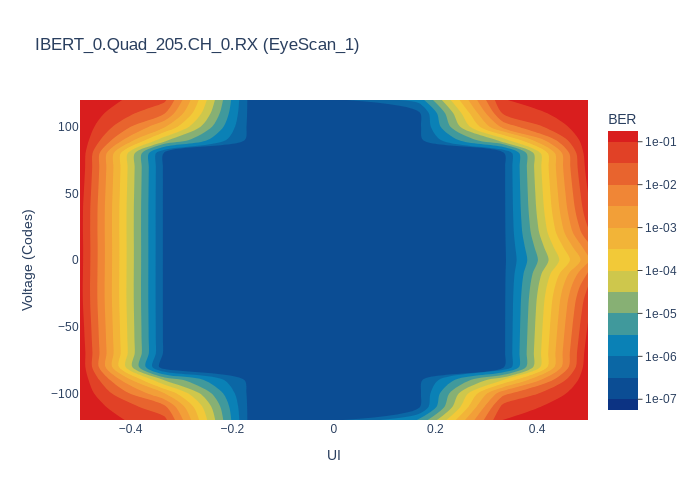

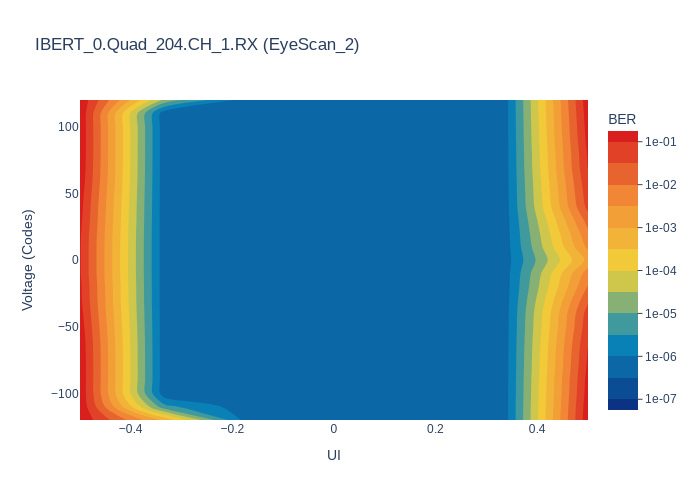

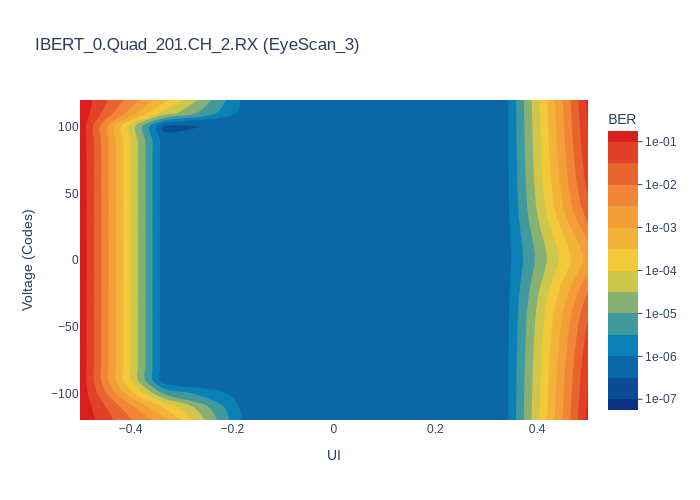

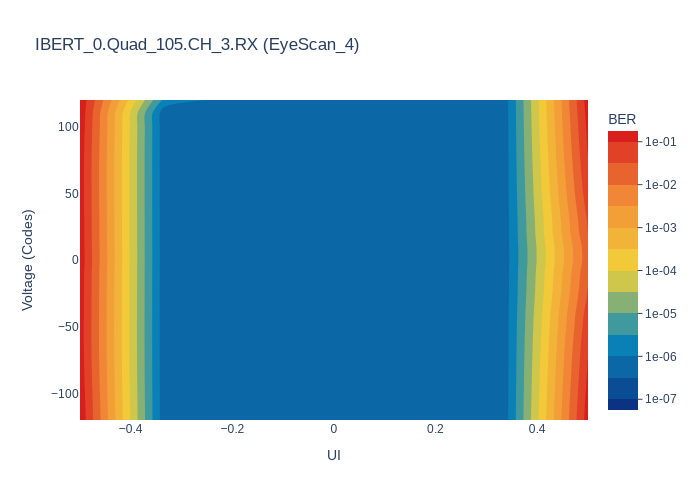

In [11]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()

# IBERT Sweep Example

This step begins the sweep example, in which for a single link we iterate through valid property values for our desired TX/RX properties, creating an eye scan for each combination of values and allowing us to identify the property values corresponding to the best eye scan. 

Note that while the eye scan example assumed that no external cable loopback was present, this example was designed to work for devices with external loopback - regardless of the property values we are sweeping over, using internal loopback would likely cause there to not be any appreciable difference in the eye scans generated by the sweep. 

For an example of an external loopback module utilized in this example, click [here](https://www.samtec.com/kits/optics-fpga/hspce-fmcp/).

Finally, for the purposes of this example, we will arbitrarily be using the Quad 205 CH0 TX to Quad 205 CH0 RX link.

## 11 - Cache Properties for Sweep.

As performing a sweep will continuously modify our RX and TX properties, we must begin our sweep by storing the current values in order to restore them after we are done.

In [12]:
link = links[0]

#Disabling internal loopback for the reasons outlined above
props = {
    link.rx.property_for_alias[RX_LOOPBACK]: "None"
}
link.rx.property.set(**props)
link.rx.property.commit(list(props.keys()))

print(f"\n----- {link.name} -----")

orig_precursor = list(link.tx.property.refresh(link.tx.property_for_alias[TX_PRE_CURSOR]).values())[0]
orig_postcursor = list(link.tx.property.refresh(link.tx.property_for_alias[TX_POST_CURSOR]).values())[0]
orig_diffswing = list(link.tx.property.refresh(link.tx.property_for_alias[TX_DIFFERENTIAL_SWING]).values())[0]
orig_termvolt = list(link.tx.property.refresh(link.rx.property_for_alias[RX_TERMINATION_VOLTAGE]).values())[0]

print(f"--> Original value of TX Pre Cursor - {orig_precursor}")
print(f"--> Original value of TX Post Cursor - {orig_postcursor}")
print(f"--> Original value of TX Diff Swing - {orig_diffswing}")
print(f"--> Original value of RX Termination Voltage - {orig_termvolt}")


----- Link_0 -----
--> Original value of TX Pre Cursor - User Design
--> Original value of TX Post Cursor - User Design
--> Original value of TX Diff Swing - User Design
--> Original value of RX Termination Voltage - 800mv


## 12 - Find Properties for Sweep.
In this step, we find all possible values of the properties we wish to sweep over. For the purposes of this example, only two possible values from each property are used.

In [13]:
_, tx_precursor_report = link.tx.property.report(link.tx.property_for_alias[TX_PRE_CURSOR]).popitem()
_, tx_postcursor_report = link.tx.property.report(link.tx.property_for_alias[TX_POST_CURSOR]).popitem()
_, tx_diffswing_report = link.tx.property.report(link.tx.property_for_alias[TX_DIFFERENTIAL_SWING]).popitem()
_, rx_termvolt_report = link.tx.property.report(link.rx.property_for_alias[RX_TERMINATION_VOLTAGE]).popitem()

print(f"\n----- {link.name} -----")
print(f"--> Valid values for TX Pre Cursor - {tx_precursor_report['Valid values']}")
print(f"--> Valid values for TX Post Cursor - {tx_postcursor_report['Valid values']}")
print(f"--> Valid values for TX Diff Swing - {tx_diffswing_report['Valid values']}")
print(f"--> Valid values for RX Termination Voltage - {rx_termvolt_report['Valid values']}")

selected_precurs = tx_precursor_report['Valid values'][0:2]
selected_postcurs = tx_postcursor_report['Valid values'][0:2]
selected_diffswing = tx_diffswing_report['Valid values'][0:2]
selected_termvolt = rx_termvolt_report['Valid values'][0:2]


----- Link_0 -----
--> Valid values for TX Pre Cursor - ['User Design', '0 dB', '0.60 dB', '1.03 dB', '1.50 dB', '2.00 dB', '2.53 dB', '3.11 dB', '3.73 dB', '4.40 dB']
--> Valid values for TX Post Cursor - ['User Design', '0 dB', '0.21 dB', '0.29 dB', '0.77 dB', '1.27 dB', '1.81 dB', '2.38 dB', '3.01 dB', '3.63 dB', '4.35 dB', '5.24 dB', '6.16 dB', '7.19 dB', '8.31 dB', '9.65 dB', '11.20 dB', '13.10 dB', '15.40 dB', '18.80 dB']
--> Valid values for TX Diff Swing - ['User Design', '223 mV', '246 mV', '269 mV', '291 mV', '314 mV', '338 mV', '361 mV', '384 mV', '408 mV', '431 mV', '455 mV', '478 mV', '502 mV', '528 mV', '552 mV', '574 mV', '597 mV', '622 mV', '644 mV', '667 mV', '691 mV', '716 mV', '732 mV', '756 mV', '780 mV', '804 mV', '827 mV', '851 mV', '873 mV', '895 mV', '918 mV', '938 mV']
--> Valid values for RX Termination Voltage - ['300mv', '350mv', '400mv', '450mv', '500mv', '550mv', '600mv', '650mv', '700mv', '750mv', '800mv', '850mv', '900mv', '950mv', '1000mv', '1100mv']


## 13 - Perform the Sweep.
Iteration over combinations of property values is performed using the itertools product method, imported in the first cell of this example notebook.

This step displays the resulting eye scans, completing the sweep.

In [14]:
combinations = list(product(selected_precurs, 
                selected_postcurs, selected_diffswing, 
                    selected_termvolt))
print(f"-----Total Eye Scans in this Sweep: {len(combinations)}-----")

eye_scans = []
for (precurs, poscurs, difswing, tervolt) in combinations:
    props = {
        link.tx.property_for_alias[TX_PRE_CURSOR]: precurs,
        link.tx.property_for_alias[TX_POST_CURSOR]: poscurs,
        link.tx.property_for_alias[TX_DIFFERENTIAL_SWING]: difswing
    }
    link.tx.property.set(**props)
    link.tx.property.commit(list(props.keys()))
    
    props = {
        link.rx.property_for_alias[RX_TERMINATION_VOLTAGE]: tervolt,
    }
    link.rx.property.set(**props)
    link.rx.property.commit(list(props.keys()))
    
    eye_scan = create_eye_scans(target_objs=link)[0]
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 10
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 10
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5
    eye_scan.start()
    eye_scan.wait_till_done()
    print(f"Finished eye scan {eye_scan}")    
    title_string = f"Pre Cursor: {precurs}, Post Cursor: {poscurs}, Diff Swing: {difswing}," + "<br>" + f" Termination Voltage: {tervolt}" #, Common mode: {commode}
    eye_scans.append([eye_scan,title_string])
    





-----Total Eye Scans in this Sweep: 16-----


Finished eye scan EyeScan_5


Finished eye scan EyeScan_6


Finished eye scan EyeScan_7


Finished eye scan EyeScan_8


Finished eye scan EyeScan_9


Finished eye scan EyeScan_10


Finished eye scan EyeScan_11


Finished eye scan EyeScan_12


Finished eye scan EyeScan_13


Finished eye scan EyeScan_14


Finished eye scan EyeScan_15


Finished eye scan EyeScan_16


Finished eye scan EyeScan_17


Finished eye scan EyeScan_18


Finished eye scan EyeScan_19


Finished eye scan EyeScan_20


## 14 - Find the Sweep's Best Eye Scan.
Using the eye scans that we have created with the sweep, we can deduce which eye scan and its corresponding properties are the most desirable based on many different, often arbitrary metrics. In this example, we will use the proportion of 0 Bit Error Rate within each eye scan. Other ways of identifying eye-scan quality could include calculating the largest width of the dark blue area, or even simply eye-balling the area of the graph. 

In this cell, we calculate our metric using the eye scan's raw data, sorting the resulting eye scans in descending order and printing them out.

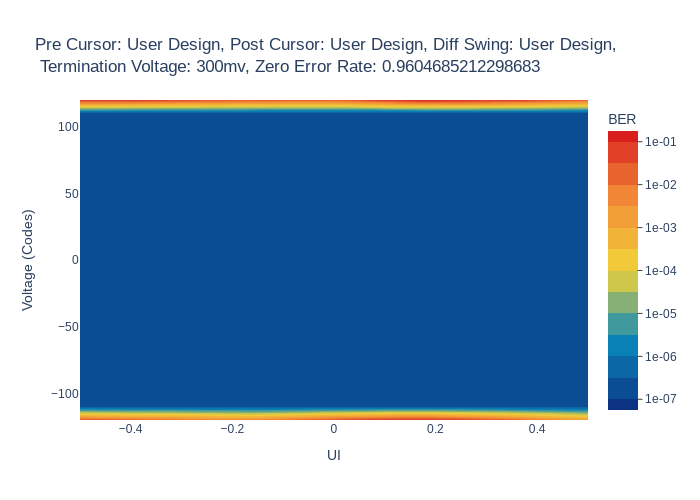

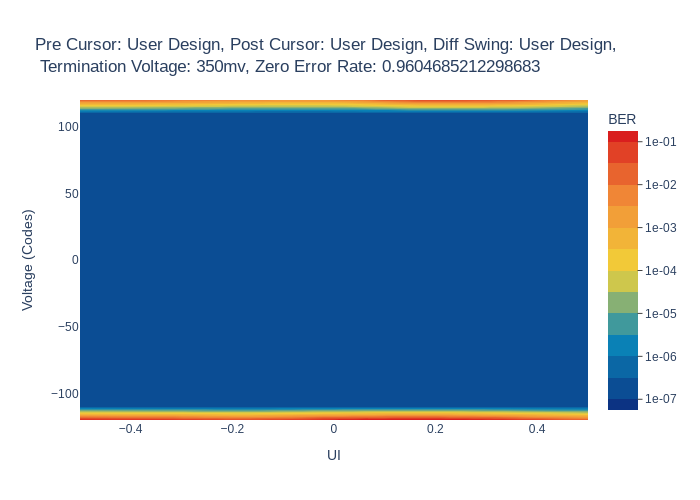

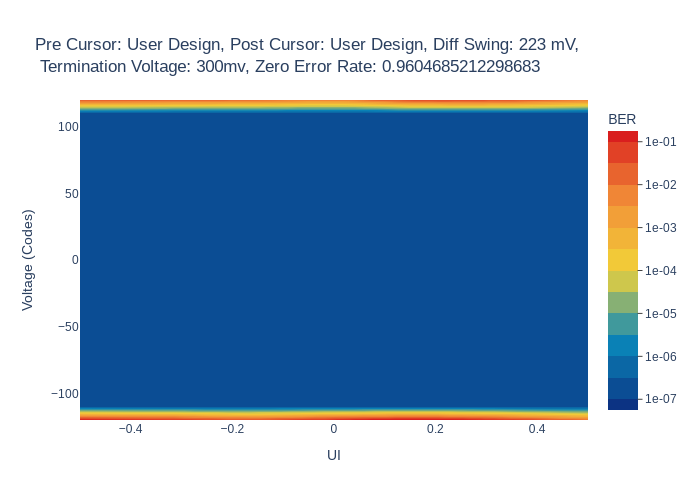

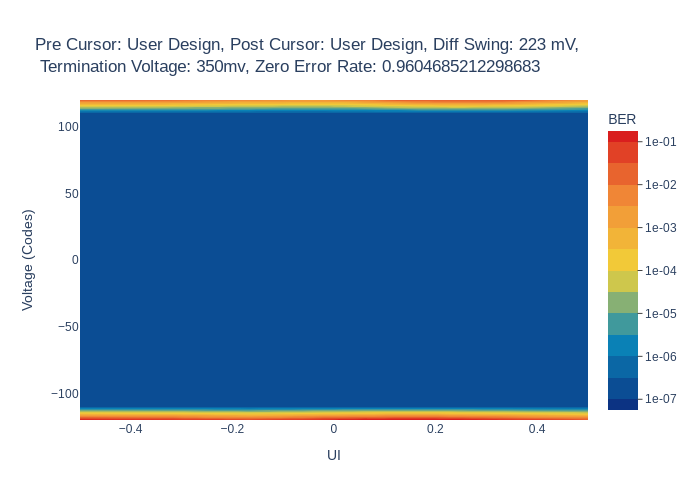

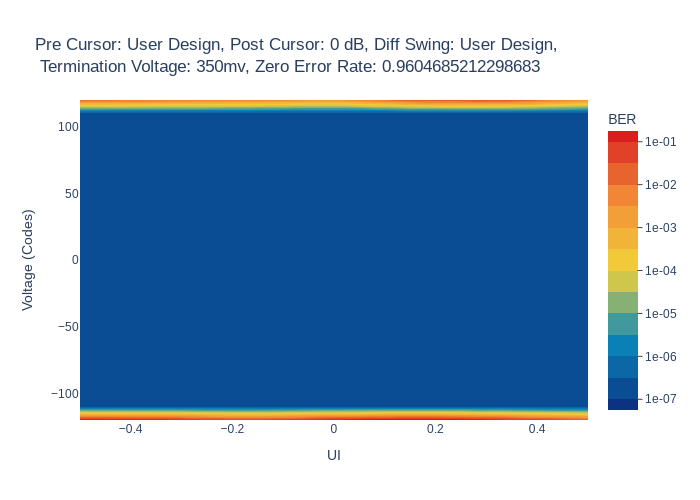

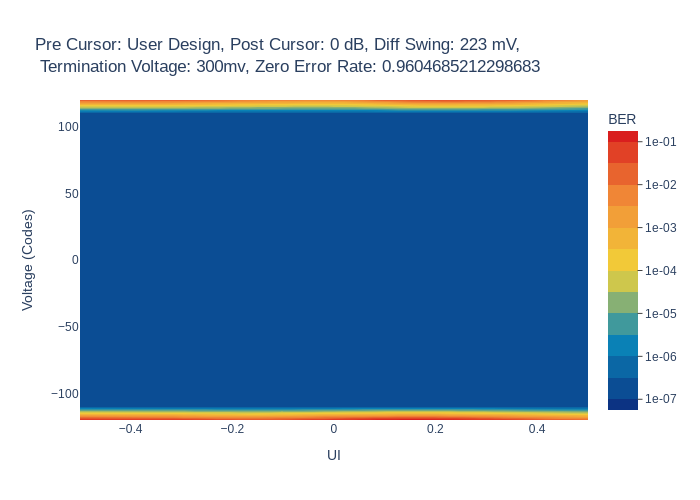

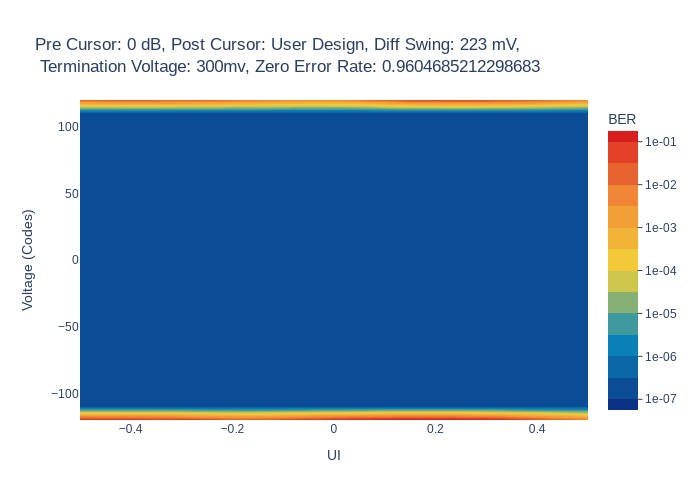

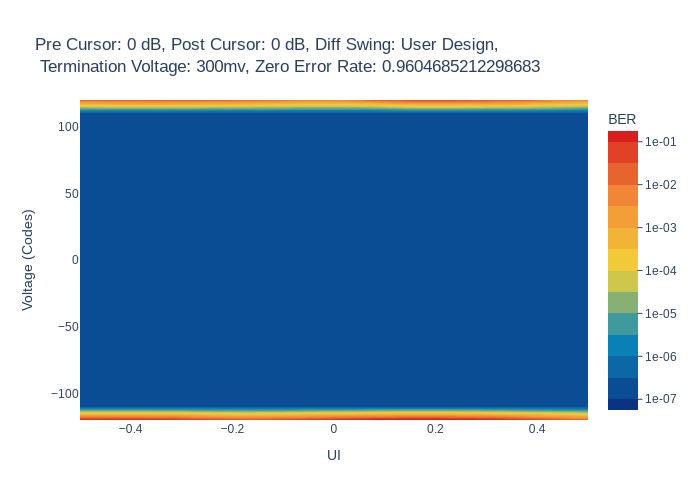

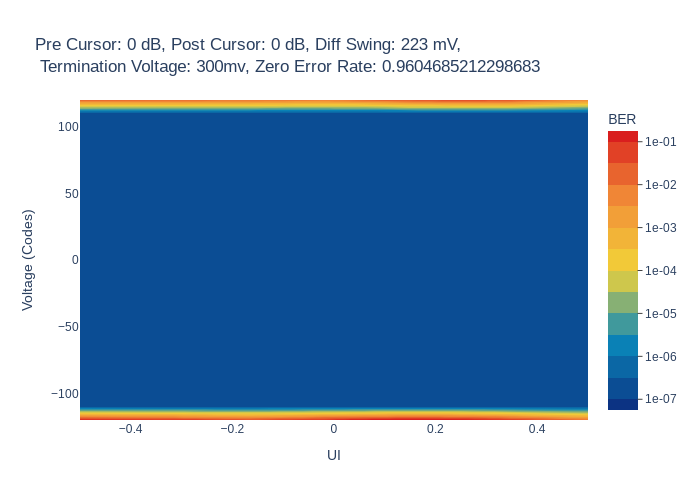

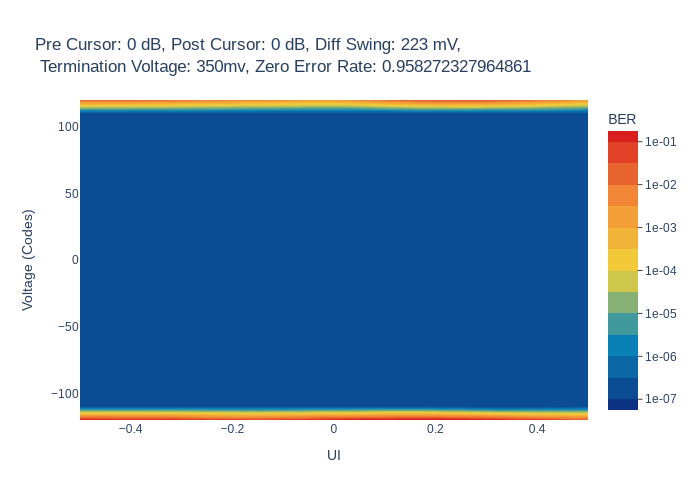

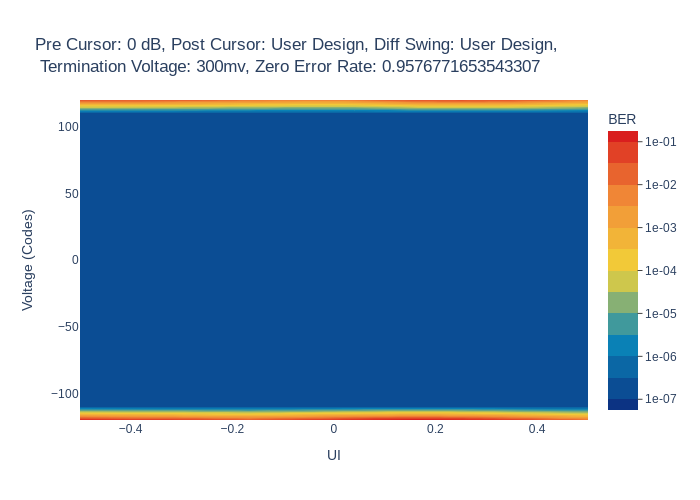

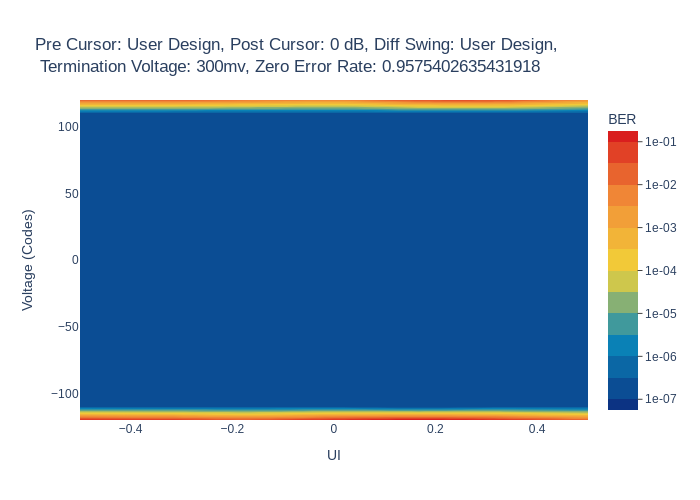

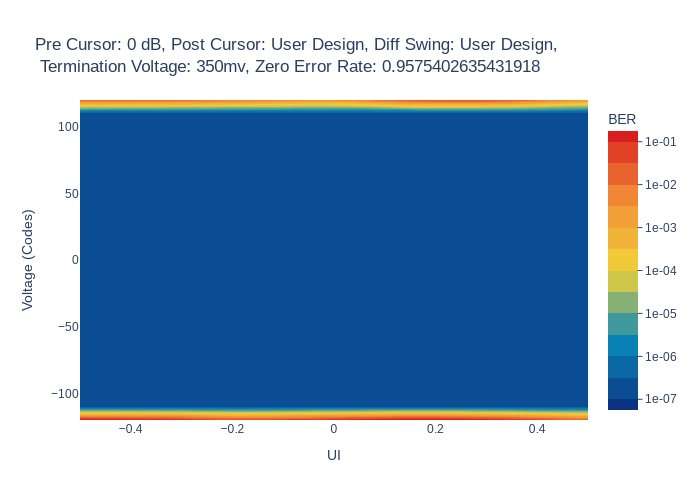

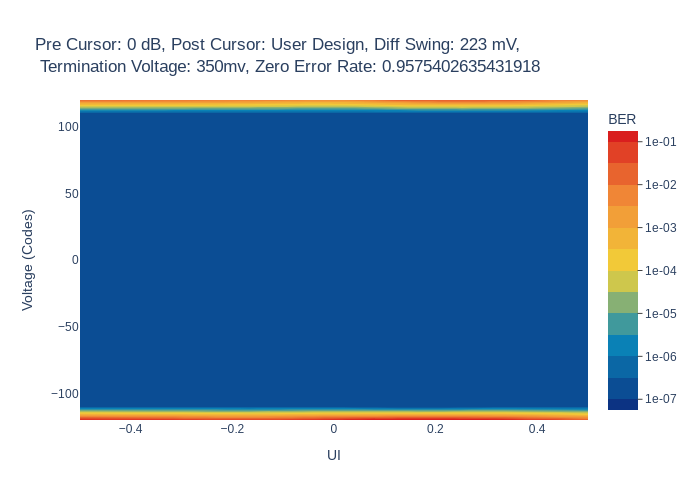

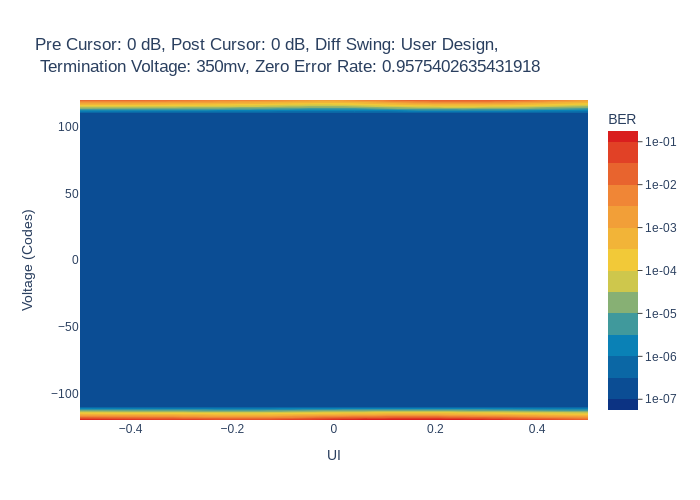

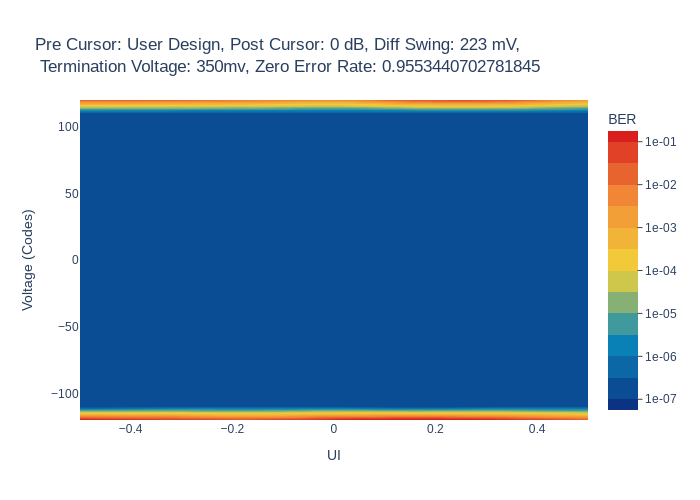

In [15]:
for scan in eye_scans:
    scan.append(sum([1 for i in scan[0].scan_data.raw.error_count if i == 0])/len(scan[0].scan_data.raw.error_count))

eye_scans.sort(key=lambda x: x[2], reverse=True)

for scan in eye_scans:
    scan[1] += f", Zero Error Rate: {scan[2]}"
    scan[0].plot.show(title=scan[1])

## 15 - Restore Original Property Values.
After completing the sweep, we must finally restore each property to their original values, which we had cached in step 11.

In [16]:
props = {
    link.tx.property_for_alias[TX_PRE_CURSOR]: orig_precursor,
    link.tx.property_for_alias[TX_POST_CURSOR]: orig_postcursor,
    link.tx.property_for_alias[TX_DIFFERENTIAL_SWING]: orig_diffswing,

}    
link.tx.property.set(**props)  
link.tx.property.commit(list(props.keys()))

props = {
    link.rx.property_for_alias[RX_TERMINATION_VOLTAGE]: orig_termvolt,

}    
link.rx.property.set(**props)  
link.rx.property.commit(list(props.keys()))


print(f"Post-sweep value of TX Pre Cursor: {list(link.tx.property.refresh(link.tx.property_for_alias[TX_PRE_CURSOR]).values())[0]}")
print(f"Post-sweep value of TX Post Cursor: {list(link.tx.property.refresh(link.tx.property_for_alias[TX_POST_CURSOR]).values())[0]}")
print(f"Post-sweep value of TX Diff Swing: {list(link.tx.property.refresh(link.tx.property_for_alias[TX_DIFFERENTIAL_SWING]).values())[0]}")
print(f"Post-sweep value of RX Termination Voltage Cursor: {list(link.rx.property.refresh(link.rx.property_for_alias[RX_TERMINATION_VOLTAGE]).values())[0]}")

Post-sweep value of TX Pre Cursor: User Design
Post-sweep value of TX Post Cursor: User Design
Post-sweep value of TX Diff Swing: User Design
Post-sweep value of RX Termination Voltage Cursor: 800mv


In [17]:
## When done with testing, close the connection
delete_session(session)